# Grad-CAM Visualization

This notebook demonstrates how to:

1. **Import necessary libraries**
2. **Load and inspect pre-split datasets** (`nod5`, `nod2`, `full5`, `full2`) from `.npz` files.
3. **Load pretrained Keras models** optimized for different classification schemes.
4. **Implement Grad-CAM++**:
   - Compute class-specific heatmaps from the last convolutional layer.
   - Overlay heatmaps on input slices for visual explanation.
5. **Visualize results** for both 5-class and 2-class nodule and full slices.

---


## Imports
Import required libraries for TensorFlow, numerical operations, plotting, and Keras backend.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colormaps
from tensorflow.keras import backend as K

## Load Data
Load NPZ datasets, print their shapes, and return train/val/test splits

In [ ]:
def load_print_merge(npz_path, mode):
    data = np.load(npz_path)
    print(f"Shapes of {mode}:")
    for key, arr in data.items():
        print(f"  {key}: {arr.shape}")
    return (data['X_train'], data['y_train'],
            data['X_val'],   data['y_val'],
            data['X_test'],  data['y_test'])

_, _, _, _, X_test_nod5, y_test_nod5 = load_print_merge('/kaggle/input/nod5_mix.npz', 'Nod5')
_, _, _, _, X_test_nod2, y_test_nod2 = load_print_merge('/kaggle/input/nod2_trad.npz', 'Nod2')
_, _, _, _, X_test_full5, y_test_full5 = load_print_merge('/kaggle/input/full5_mix.npz', 'Full5')
_, _, _, _, X_test_full2, y_test_full2 = load_print_merge('/kaggle/input/full2_trad.npz', 'Full2')

Shapes of Nod5:
  X_train: (4365, 224, 224)
  y_train: (4365,)
  X_val: (237, 224, 224)
  y_val: (237,)
  X_test: (237, 224, 224)
  y_test: (237,)
Shapes of Nod2:
  X_train: (2866, 224, 224)
  y_train: (2866,)
  X_val: (237, 224, 224)
  y_val: (237,)
  X_test: (237, 224, 224)
  y_test: (237,)
Shapes of Full5:
  X_train: (4365, 224, 224)
  y_train: (4365,)
  X_val: (237, 224, 224)
  y_val: (237,)
  X_test: (237, 224, 224)
  y_test: (237,)
Shapes of Full2:
  X_train: (2866, 224, 224)
  y_train: (2866,)
  X_val: (237, 224, 224)
  y_val: (237,)
  X_test: (237, 224, 224)
  y_test: (237,)


## Load Models
Load pre-trained Keras models from file paths

In [ ]:
def load_best_model(filepath) -> tf.keras.Model:
    return tf.keras.models.load_model(filepath, compile=True)

model_nod5 = load_best_model("/kaggle/input/best_model_overall_conservative_nod5.keras")
model_nod2 = load_best_model("/kaggle/input/best_model_overall_conservative_nod2.keras")
model_full5 = load_best_model("/kaggle/input/best_model_overall_moderate_full5.keras")
model_full2 = load_best_model("/kaggle/input/best_model_overall_moderate_full2.keras")

## Grad-CAM++
Utilities for RGB conversion, label normalization, and Grad-CAM++ visualization.

In [ ]:
def ensure_rgb(x):
    """Ensure tensor has 3 color channels."""
    if x.ndim == 4 and x.shape[-1] == 1:
        x = tf.repeat(x, repeats=3, axis=-1)
    elif x.ndim == 3 and x.shape[-1] != 3:
        x = tf.stack([x, x, x], axis=-1)
    return tf.cast(x, tf.float32)

def ensure_zero_based(y):
    """Shift labels so the minimum index is 0."""
    y = np.asarray(y)
    return y - y.min()

def last_conv_layer_name(model):
    """Return the name of the last layer with a 4D output."""
    for layer in reversed(model.layers):
        shape = K.int_shape(layer.output)
        if shape and len(shape) == 4:
            return layer.name
    raise ValueError(
        "No 4D layer found in model.layers – specify conv_layer manually."
    )

def gradcam_pp_heatmap(model, img_tensor, conv_layer_name=None, class_index=None):
    if conv_layer_name is None:
        conv_layer_name = last_conv_layer_name(model)
    heatmap_model = tf.keras.Model(
        model.inputs,
        [model.get_layer(conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as t3:
        with tf.GradientTape() as t2:
            with tf.GradientTape() as t1:
                conv_out, preds = heatmap_model(img_tensor)
                t1.watch(conv_out)
                if class_index is None:
                    class_index = tf.argmax(preds[0])
                score = preds[:, class_index]
            first = t1.gradient(score, conv_out)
        second = t2.gradient(first, conv_out)
    third = t3.gradient(second, conv_out)

    conv_out_np = conv_out.numpy()[0]
    first_np    = first.numpy()[0]
    second_np   = second.numpy()[0]
    third_np    = third.numpy()[0]
    gsum        = np.sum(conv_out_np, axis=(0, 1))

    eps   = 1e-8
    denom = 2 * second_np + third_np * gsum[None, None, :]
    alphas = second_np / (denom + eps)
    sum_per_ch = np.sum(alphas, axis=(0, 1))
    alphas /= (sum_per_ch[None, None, :] + eps)
    alphas = np.nan_to_num(alphas)

    grads_pos    = np.maximum(first_np, 0)
    deep_weights = np.sum(grads_pos * alphas, axis=(0, 1))
    cam = np.sum(conv_out_np * deep_weights[None, None, :], axis=-1)

    if not np.any(cam > 0):
        return np.zeros_like(cam)

    heatmap = np.maximum(cam, 0)
    return heatmap / (np.max(heatmap) + eps)

def overlay_heatmap(img, heatmap, alpha=0.4, cmap='jet'):
    """Overlay a heatmap on an image."""
    heatmap = np.nan_to_num(heatmap)
    H, W, _ = img.shape
    heatmap_resized = tf.image.resize(
        heatmap[..., None],
        size=(H, W),
        method='bilinear'
    )[..., 0].numpy()


    try:
        cmap_obj = colormaps[cmap]
    except AttributeError:
        cmap_obj = cm.get_cmap(cmap)
    heatmap_col = cmap_obj((heatmap_resized * 255).astype(np.uint8))[..., :3]

    overlay = heatmap_col * alpha + img
    overlay /= overlay.max()
    return heatmap_col, np.uint8(255 * overlay)

def normalize_for_display(x_tf):
    """Scale tensor values to [0,1] for display."""
    x = x_tf.numpy().astype(np.float32)
    mn, mx = x.min(), x.max()
    return (x - mn) / (mx - mn + 1e-8)

def show_gradcam_results(model, X_test, y_test, indices, conv_layer=None):
    """Show input, heatmap, and overlay for given test indices."""
    X = ensure_rgb(X_test)
    y = ensure_zero_based(y_test)

    n = len(indices)
    plt.figure(figsize=(12, 4 * n))
    for i, idx in enumerate(indices):
        img_tensor = X[idx:idx+1]
        true_label = int(y[idx])
        preds = model.predict(img_tensor)
        pred_label = int(np.argmax(preds[0]))

        raw = normalize_for_display(img_tensor[0])
        heat = gradcam_pp_heatmap(model, img_tensor, conv_layer_name=conv_layer, class_index=true_label)
        _, overlay_img = overlay_heatmap(raw, heat)

        for j, panel in enumerate([raw, heat, overlay_img]):
            ax = plt.subplot(n, 3, i * 3 + j + 1)
            if j == 1:
                plt.imshow(panel, cmap='jet')
            else:
                plt.imshow(panel)
            plt.axis('off')
            titles = ['Input', 'Heat-map', f'Overlay\nTrue: {true_label}, Pred: {pred_label}']
            ax.set_title(titles[j], fontsize=12)

    plt.tight_layout()
    plt.show()

### Nodule Slice with 5 class

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/tmp/ipykernel_31/1416901619.py:52: RuntimeWarning: divide by zero encountered in divide
  alphas = second_np / (denom + eps)
/tmp/ipykernel_31/1416901619.py:54: RuntimeWarning: invalid value encountered in divide
  alphas /= (sum_per_ch[None, None, :] + eps)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


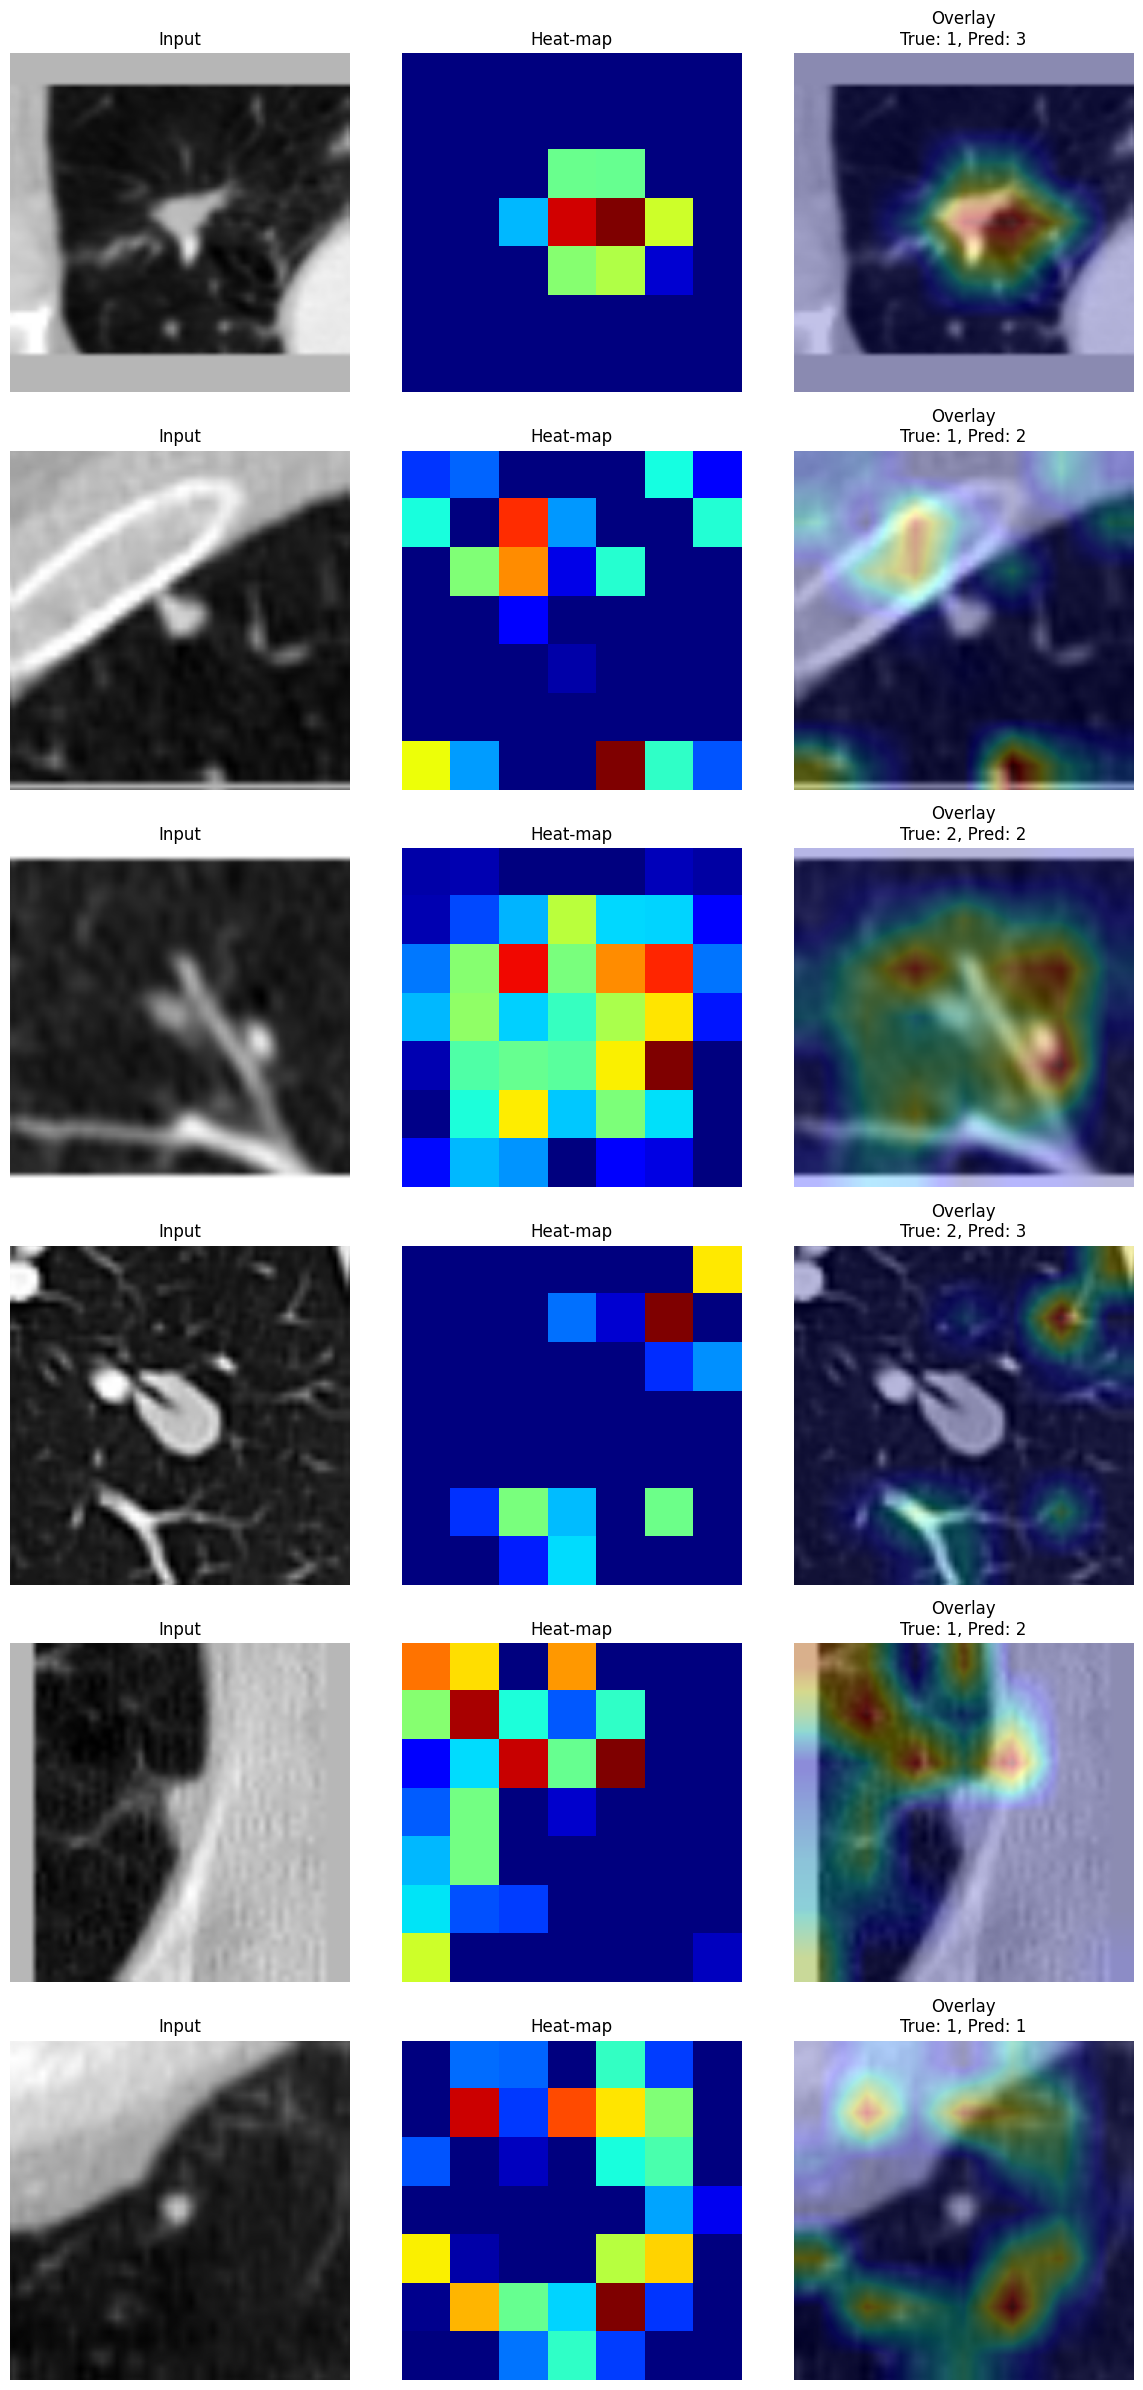

In [ ]:
sample_ids = [0, 1, 3, 5, 7, 9]
show_gradcam_results(model_nod5, X_test_nod5, y_test_nod5, sample_ids)

### Nodule Slice with 2 class

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


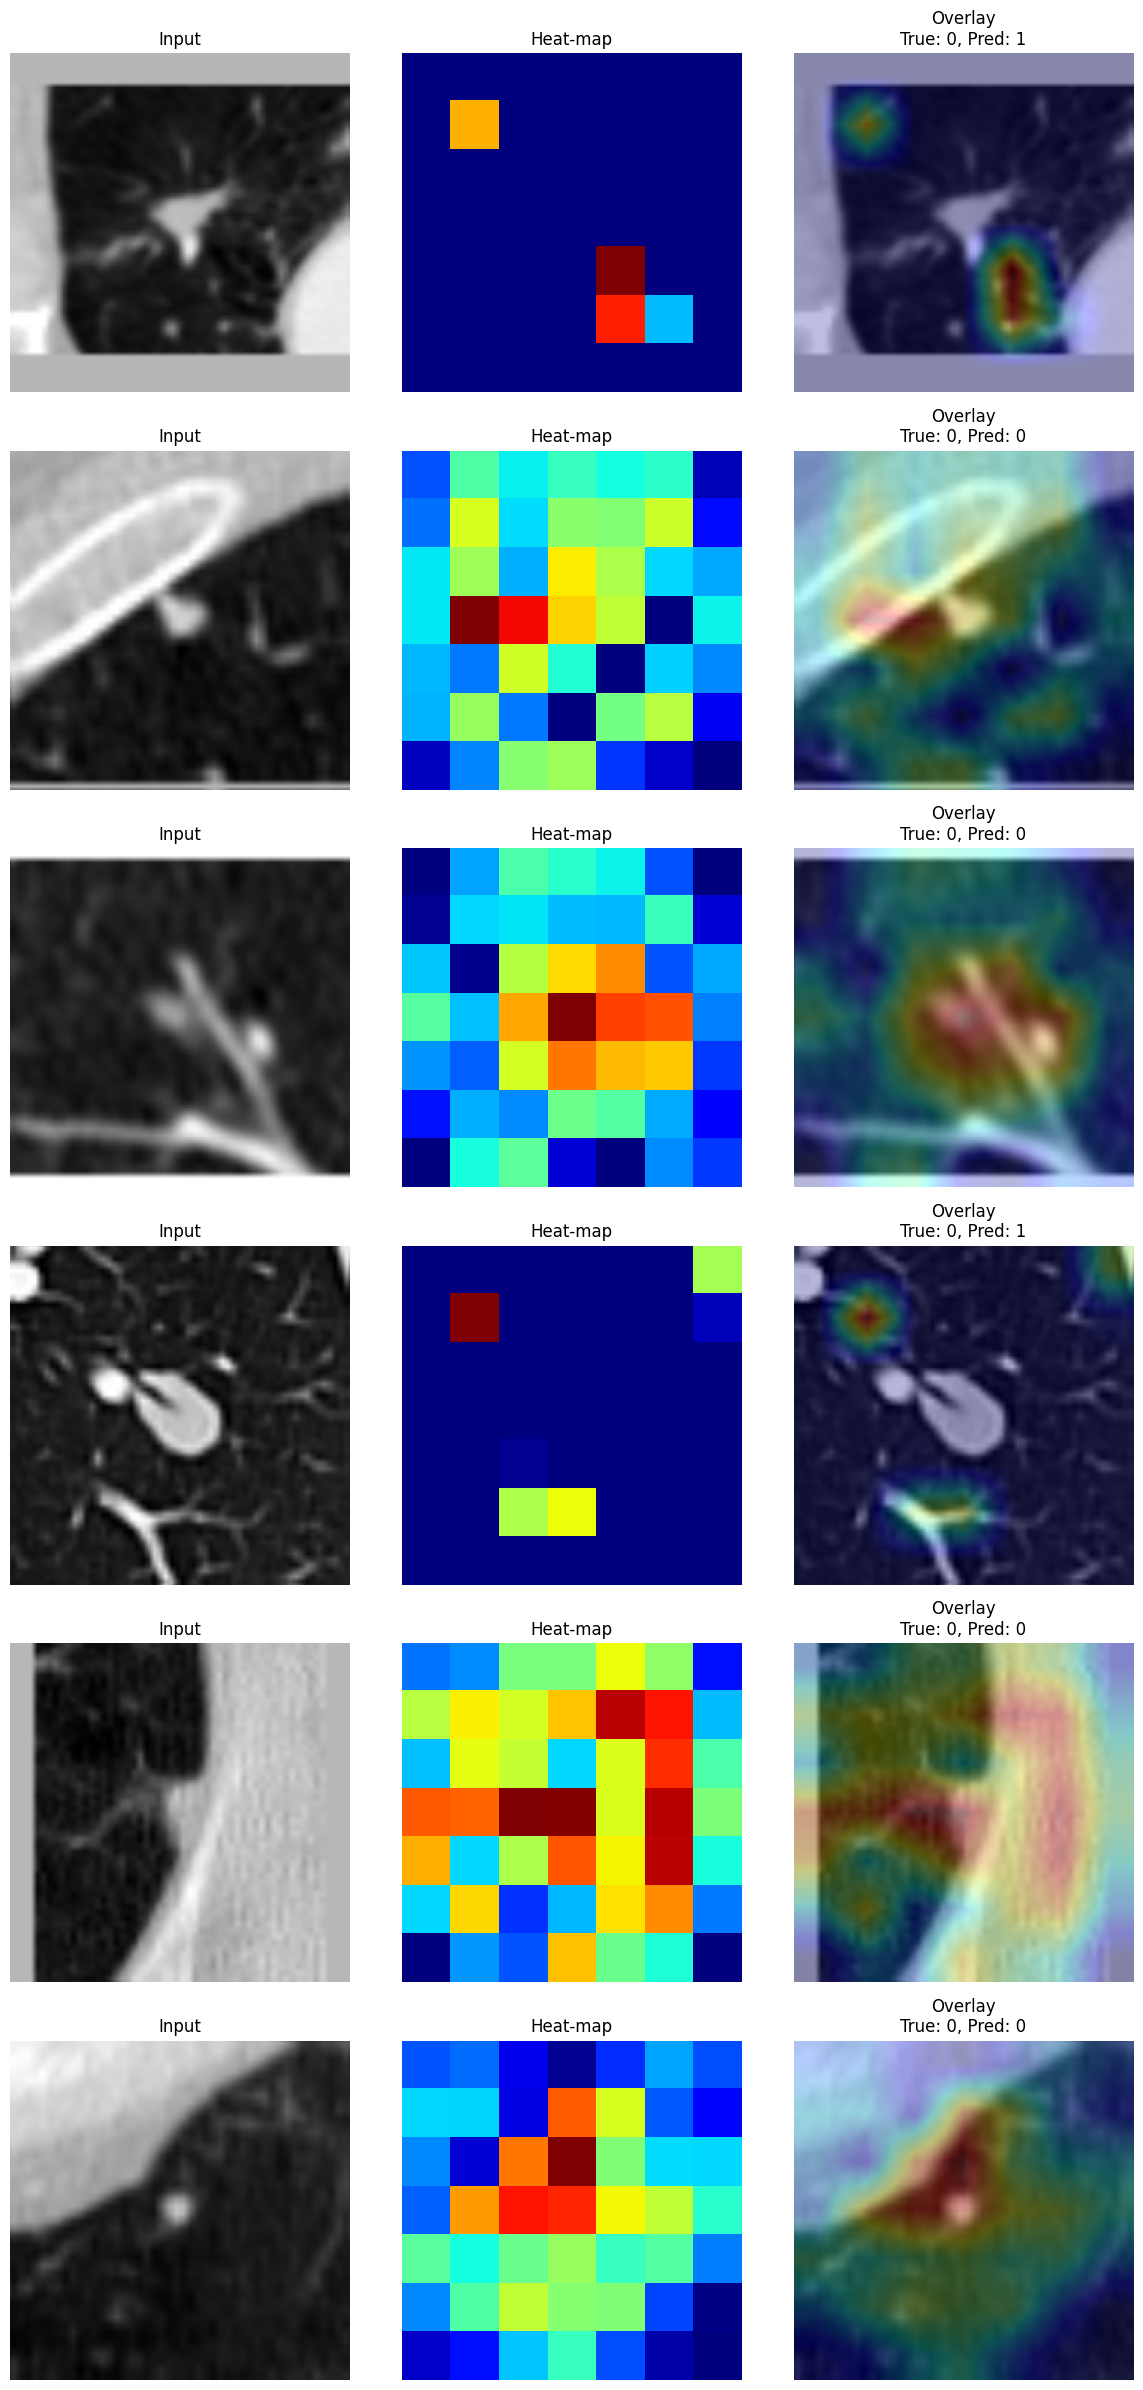

In [ ]:
sample_ids = [0, 1, 3, 5, 7, 9]
show_gradcam_results(model_nod2, X_test_nod2, y_test_nod2, sample_ids)

### Full Slice with 5 class

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


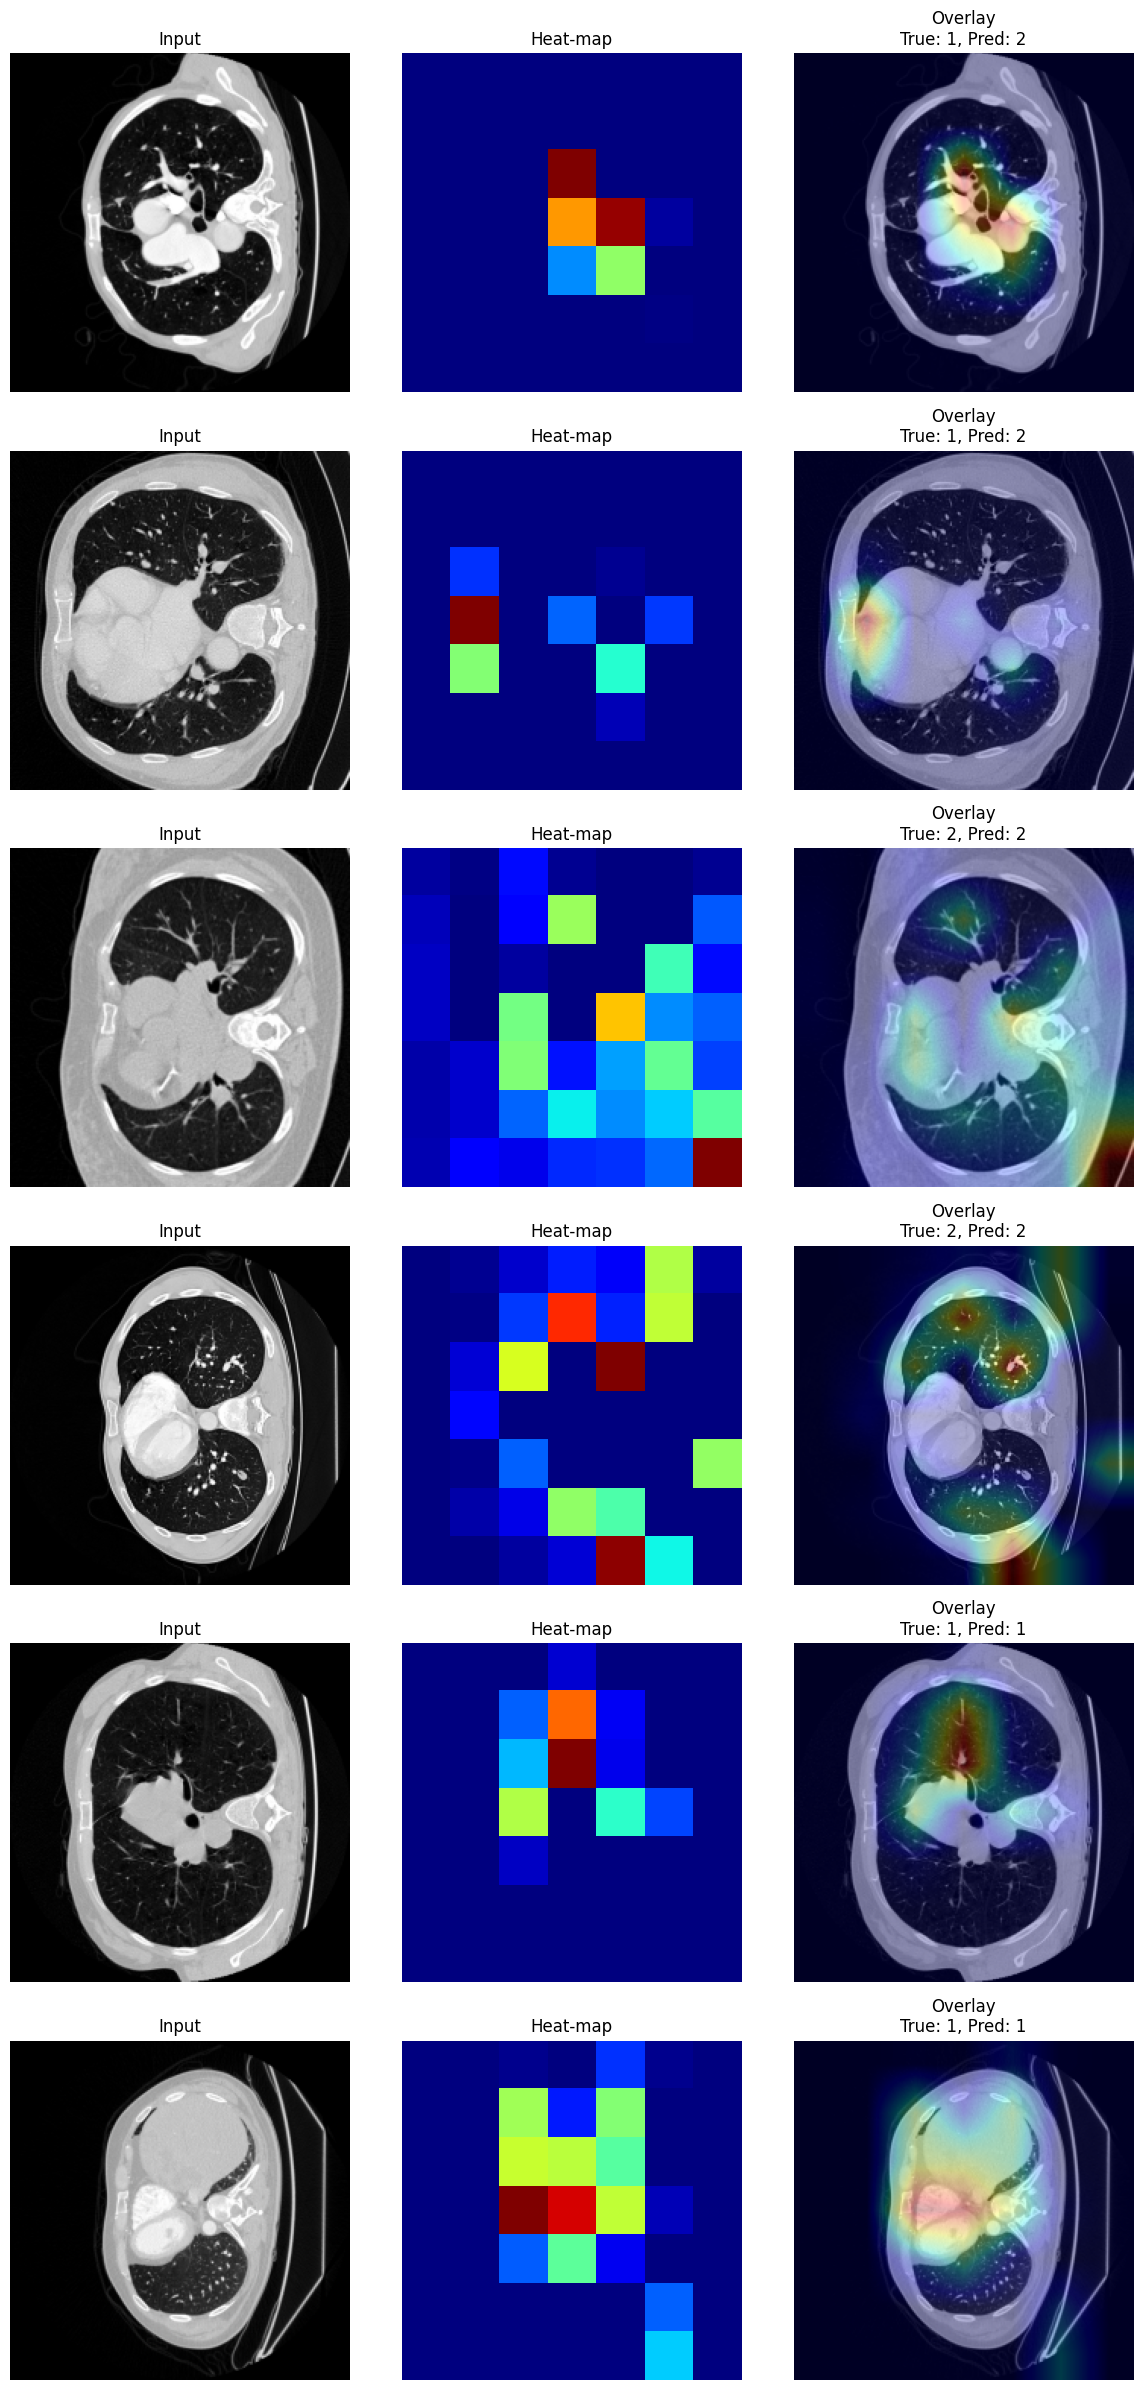

In [ ]:
sample_ids = [0, 1, 3, 5, 7, 9]
show_gradcam_results(model_full5, X_test_full5, y_test_full5, sample_ids)

### Full Slice with 2 class

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/tmp/ipykernel_31/1416901619.py:52: RuntimeWarning: divide by zero encountered in divide
  alphas = second_np / (denom + eps)
/tmp/ipykernel_31/1416901619.py:52: RuntimeWarning: invalid value encountered in divide
  alphas = second_np / (denom + eps)
/tmp/ipykernel_31/1416901619.py:54: RuntimeWarning: invalid value encountered in divide
  alphas /= (sum_per_ch[None, None, :] + eps)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


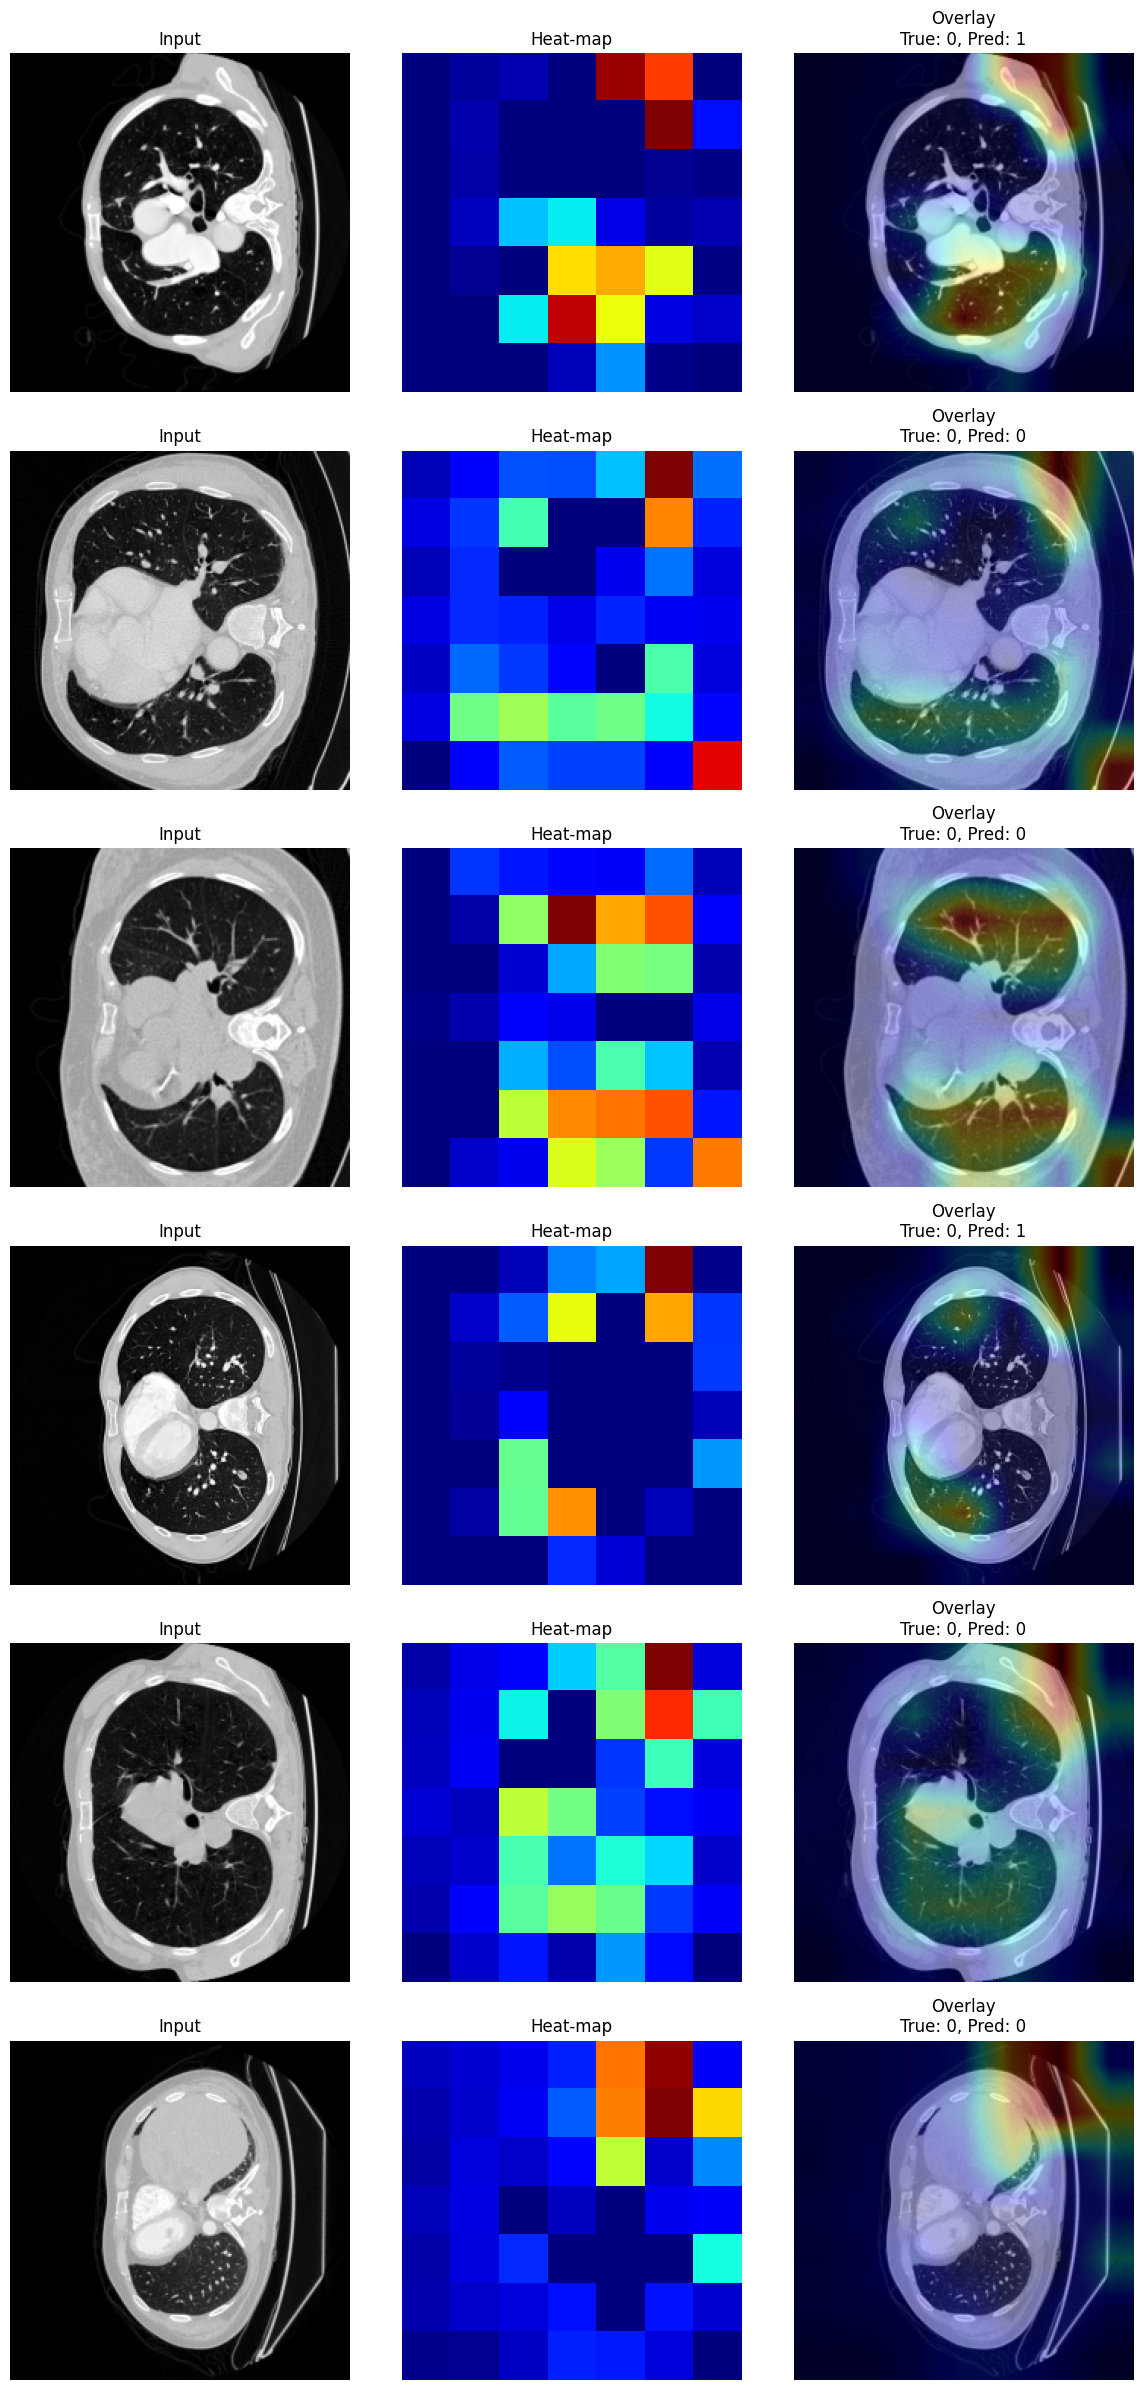

In [ ]:
sample_ids = [0, 1, 3, 5, 7, 9]
show_gradcam_results(model_full2, X_test_full2, y_test_full2, sample_ids)